## 01. EEG BASICS 
**Purpose**: Load EGG data, inspect metadata, plot raw signals, compute PSD. 



In [4]:
import sys
sys.path.append("../../") 

from neurolib.eeg_meg.io import load_eeg_raw
from neurolib.eeg_meg.visualization import plot_raw, plot_psd

### Loading Data
We load a sample EEG recording. The EEG data is stored in the Raw object, which keeps track of all channels and the continuous signal over time.
This reads in the EEG file and returns an MNE Raw object.

The Raw object contains:
- Continuous voltage signals for each EEG channel over time
- Sampling frequency (Hz)
- Channel names and types
- Timing and metadata

In [5]:
raw = load_eeg_raw()

Extracting EDF parameters from /Users/yibeisita/Documents/neuro-ai-playground/datasets/eeg_sample/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...


### Inspect Info
Inspect the raw data info to understand the sampling rate, channel count, and acquisition parameters.
The info object contains key information about the recording:
- 'sfreq': sampling frequency (how many samples per second)
- 'ch_names': names of EEG channels (electrodes)
- 'nchan': number of channels
- 'meas_date': date of recording
- 'highpass'/'lowpass' filters applied during acquisition

This metadata helps us understand the structure and quality of the EEG data.

In [6]:
print("\n--- Info Metadata---")
print(raw.info)


--- Info Metadata---
<Info | 8 non-empty values
 bads: []
 ch_names: Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
 subject_info: <subject_info | his_id: X, sex: 0, last_name: X>
>


### Plot Raw EEG

Plot raw signals. The plot shows the voltage over time for each EEG channel, each channel corresponds to one electrode.
Key points to observe:
- Spontaneous EEG oscillations (alpha, beta rhythms)
- Artifacts such as eye blinks or muscle activity
- Differences in amplitude and signal quality across channels

This visualization gives an overview of the EEG signal before any preprocessing.

**Note:**
- This plot uses the **Matplotlib backend** for compatibility with Jupyter Notebooks. 
- It shows EEG signals as a static 2D plot — scrolling and annotations are disabled.  
- For full interactivity (scrolling, marking bad channels, etc.), run this cell in a standalone Python script or environment with Qt support.

Using matplotlib as 2D backend.


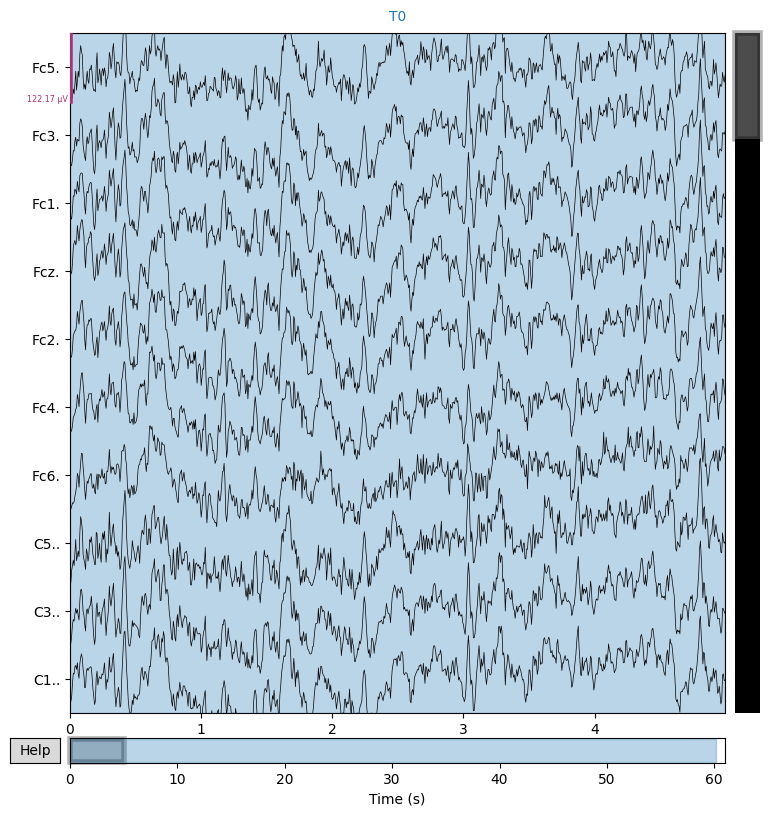

In [7]:
plot_raw(raw, n_channels=10, duration=5)

### Plot Power Spectral Density (PSD)
The PSD shows how much power exists at each frequency. Peaks may correspond to specific brain rhythms, like alpha waves when the eyes are closed.

The Power Spectral Density (PSD) shows the signal power across frequency bands.

EEG frequency bands commonly observed:
- Delta: 0.5–4 Hz
- Theta: 4–8 Hz
- Alpha: 8–13 Hz
- Beta: 13–30 Hz
- Gamma: 30–100 Hz

This plot helps identify which frequency bands dominate in your EEG recording.

Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).


/Users/yibeisita/Documents/neuro-ai-playground/tutorials/01_foundations/../../neurolib/eeg_meg/visualization.py:12: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  psd.plot(dB=True, picks="data", exclude="bads", amplitude=False)
/Users/yibeisita/Documents/neuro-ai-playground/.venv/lib/python3.11/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


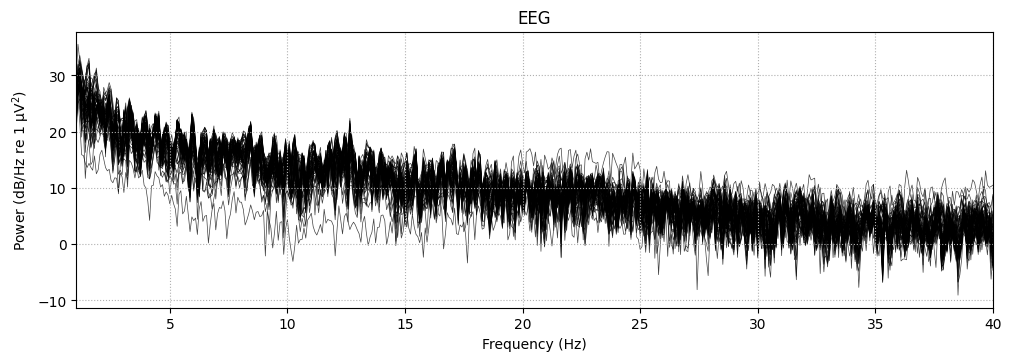

In [8]:
%matplotlib inline
plot_psd(raw)